In [1]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [2]:
# generate data
nb_query = 20
query = np.array([i+1 for i in range(nb_query) for x in range(int(np.ceil(np.abs(np.random.normal(0,scale=15))+2)))])
doc_features = np.random.random((len(query), 10))
doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i])
        xj.append(doc_features[j])
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

In [3]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=50, batch_size=1, validation_data=([xi_test, xj_test], pij_test))


Epoch 1/50
2758/2758 [==============================] - 2s 785us/step - loss: 0.6809 - val_loss: 0.6663
Epoch 2/50
2758/2758 [==============================] - 2s 729us/step - loss: 0.6641 - val_loss: 0.6514
Epoch 3/50
2758/2758 [==============================] - 2s 732us/step - loss: 0.6497 - val_loss: 0.6330
Epoch 4/50
2758/2758 [==============================] - 2s 709us/step - loss: 0.6366 - val_loss: 0.6225
Epoch 5/50
2758/2758 [==============================] - 2s 732us/step - loss: 0.6252 - val_loss: 0.6113
Epoch 6/50
2758/2758 [==============================] - 2s 734us/step - loss: 0.6141 - val_loss: 0.6059
Epoch 7/50
2758/2758 [==============================] - 2s 715us/step - loss: 0.6057 - val_loss: 0.5968
Epoch 8/50
2758/2758 [==============================] - 2s 724us/step - loss: 0.5954 - val_loss: 0.5888
Epoch 9/50
2758/2758 [==============================] - 2s 778us/step - loss: 0.5865 - val_loss: 0.5776
Epoch 10/50
2758/2758 [==============================] - 2s 741u

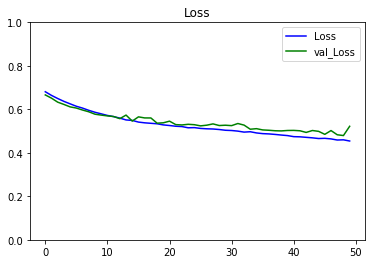

In [4]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)
